In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from typing import Tuple
import warnings

warnings.filterwarnings("ignore")

# Daten laden (angenommen, sie sind verfügbar)
orders = pd.read_parquet("orders.parquet")
tips_public = pd.read_csv("tips_public.csv")


Removed 62051 orders from days with less than 10 orders.
Remaining days: 455, Remaining orders: 1401581


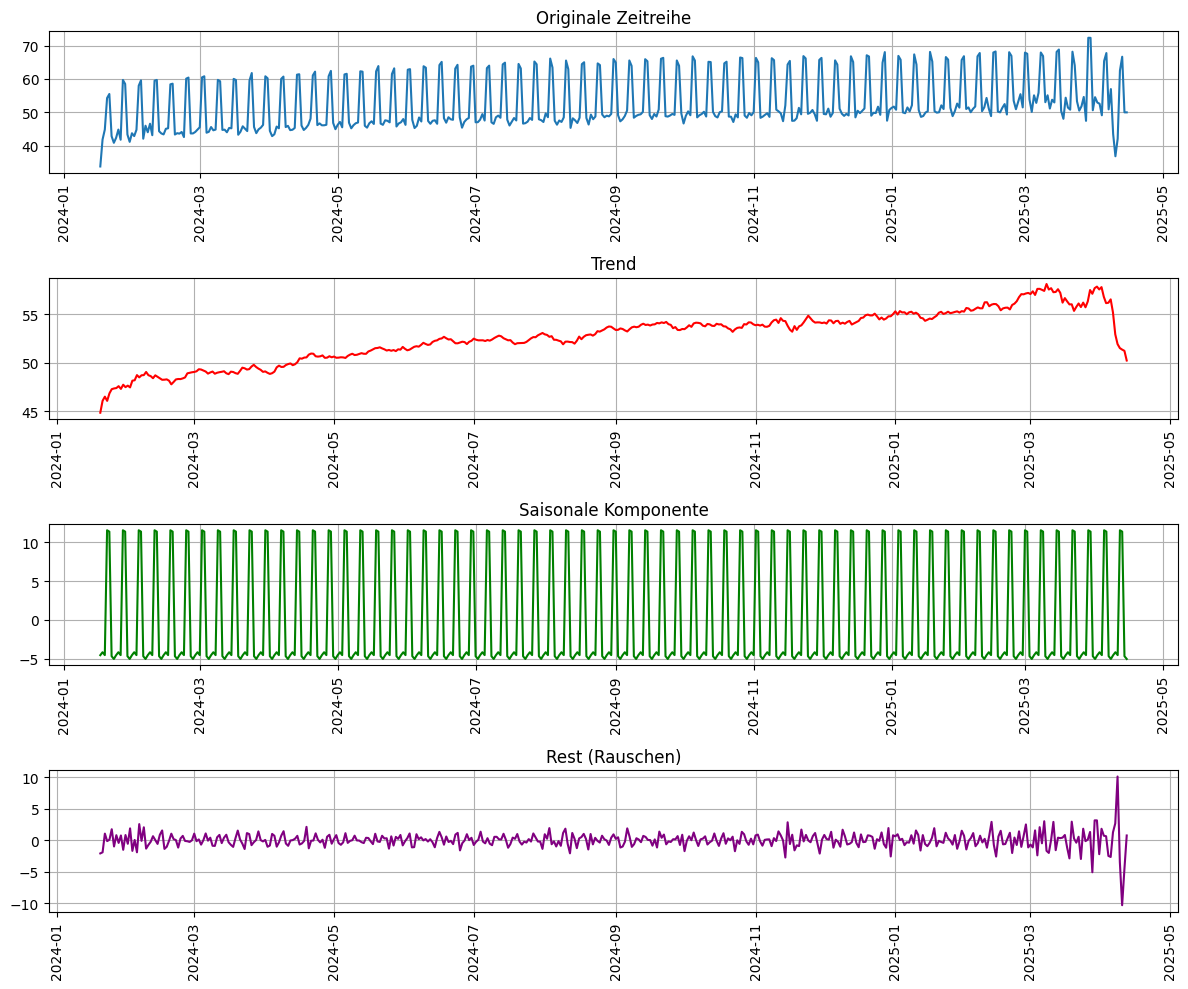

RMSE der SARIMA-Vorhersagen: 2.88


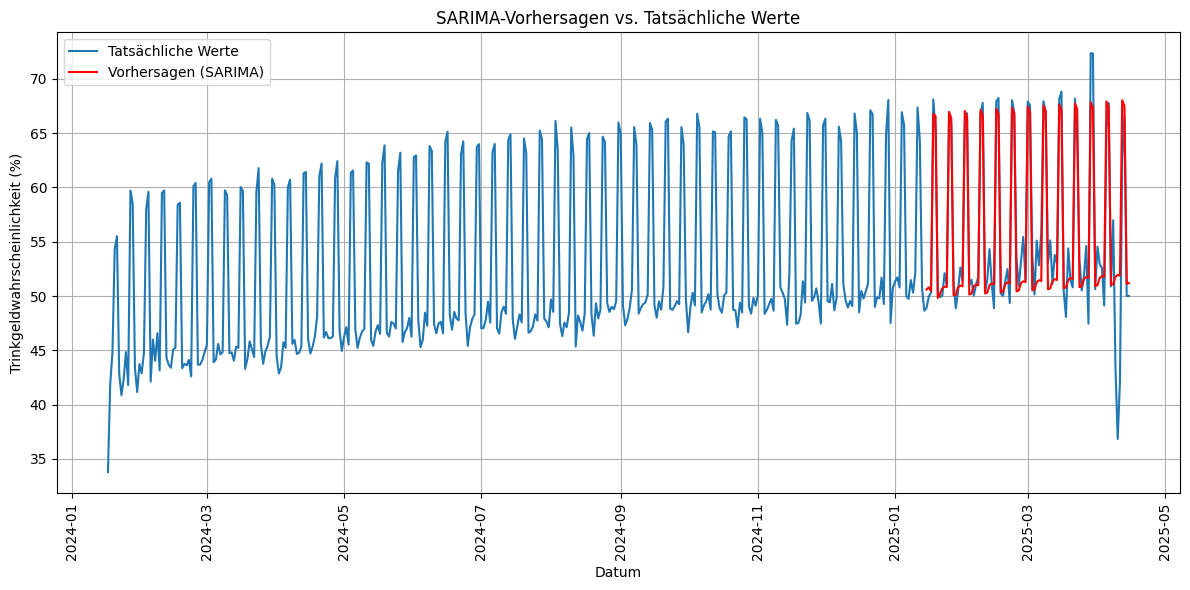

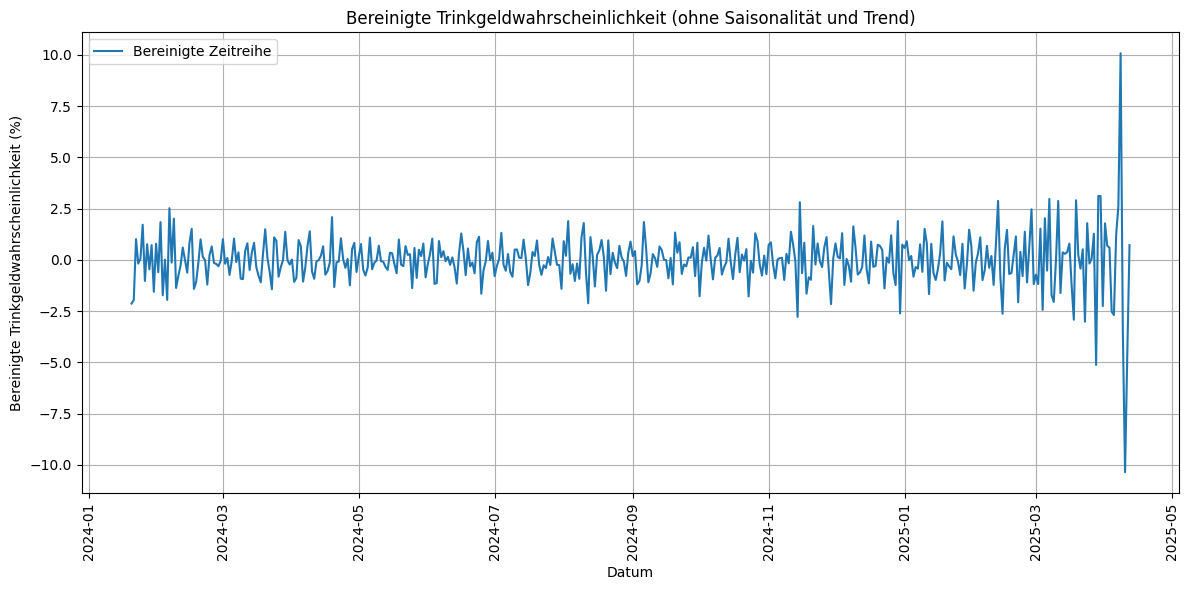

In [4]:
def prepare_data(orders: pd.DataFrame, tips_public: pd.DataFrame, min_orders: int = 10) -> pd.DataFrame:
    """
    Bereitet die Daten vor: Mergen, Datumsformatierung, Filtern von Tagen mit wenigen Bestellungen.
    """
    # Merge orders und tips_public
    df = orders[['order_id', 'order_date']].merge(tips_public[['order_id', 'tip']], on='order_id', how='inner')
    df['order_date'] = pd.to_datetime(df['order_date'])

    # Filtere Tage mit weniger als min_orders Bestellungen
    daily_counts = df.groupby(df['order_date'].dt.date)['order_id'].count().reset_index(name='order_count')
    valid_dates = pd.to_datetime(daily_counts[daily_counts['order_count'] >= min_orders]['order_date'])
    df = df[df['order_date'].dt.date.isin(valid_dates.dt.date)]
    print(f"Removed {len(orders) - len(df)} orders from days with less than {min_orders} orders.")
    print(f"Remaining days: {len(valid_dates)}, Remaining orders: {len(df)}")

    return df

def calculate_seasonal_components(df: pd.DataFrame, period: str = 'D') -> Tuple[pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Berechnet tägliche/wöchentliche Saisonalität und langfristigen Trend.
    """
    # Aggregiere Trinkgeldwahrscheinlichkeit pro Tag
    df['time_period'] = df['order_date'].dt.to_period(period).apply(lambda x: x.to_timestamp())
    tip_percentage = df.groupby('time_period')['tip'].mean().reset_index()
    tip_percentage = tip_percentage.rename(columns={'tip': 'tip_percentage'})  # Rename 'tip' to 'tip_percentage'
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100
    tip_percentage = tip_percentage.set_index('time_period')

    # Saisonale Dekomposition (wöchentlich, period=7)
    decomposition = seasonal_decompose(tip_percentage['tip_percentage'], model='additive', period=7)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    return tip_percentage, trend, seasonal, resid

def plot_decomposition(tip_percentage: pd.DataFrame, trend: pd.Series, seasonal: pd.Series, resid: pd.Series) -> None:
    """
    Visualisiert die saisonale Dekomposition.
    """
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(tip_percentage.index, tip_percentage['tip_percentage'], label='Original')
    plt.title('Originale Zeitreihe')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.subplot(412)
    plt.plot(trend.index, trend, label='Trend', color='red')
    plt.title('Trend')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.subplot(413)
    plt.plot(seasonal.index, seasonal, label='Saisonal', color='green')
    plt.title('Saisonale Komponente')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.subplot(414)
    plt.plot(resid.index, resid, label='Rest', color='purple')
    plt.title('Rest (Rauschen)')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def fit_sarima_model(tip_percentage: pd.DataFrame, seasonal_period: int = 7, train_split: float = 0.8) -> Tuple[np.ndarray, float]:
    """
    Passt ein SARIMA-Modell an die bereinigten Daten an und gibt Vorhersagen sowie RMSE zurück.
    """
    y = tip_percentage['tip_percentage'].dropna()
    train_size = int(len(y) * train_split)
    train, test = y[:train_size], y[train_size:]

    # SARIMA-Modell: (1,1,1)(1,1,1,7) als Beispiel
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_period))
    fit_model = model.fit(disp=False)

    # Vorhersagen
    predictions = fit_model.forecast(steps=len(test))
    rmse = np.sqrt(mean_squared_error(test, predictions))

    return predictions, rmse

def plot_predictions(tip_percentage: pd.DataFrame, predictions: np.ndarray, train_split: float = 0.8) -> None:
    """
    Visualisiert die Vorhersagen im Vergleich zu den tatsächlichen Werten.
    """
    train_size = int(len(tip_percentage) * train_split)
    test_index = tip_percentage.index[train_size:]

    plt.figure(figsize=(12, 6))
    plt.plot(tip_percentage.index, tip_percentage['tip_percentage'], label='Tatsächliche Werte')
    plt.plot(test_index, predictions, label='Vorhersagen (SARIMA)', color='red')
    plt.title('SARIMA-Vorhersagen vs. Tatsächliche Werte')
    plt.xlabel('Datum')
    plt.ylabel('Trinkgeldwahrscheinlichkeit (%)')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    # Daten vorbereiten
    df = prepare_data(orders, tips_public, min_orders=10)

    # Saisonale Komponenten berechnen
    tip_percentage, trend, seasonal, resid = calculate_seasonal_components(df, period='D')
    plot_decomposition(tip_percentage, trend, seasonal, resid)

    # SARIMA-Modell anpassen
    predictions, rmse = fit_sarima_model(tip_percentage, seasonal_period=7, train_split=0.8)
    print(f"RMSE der SARIMA-Vorhersagen: {rmse:.2f}")
    plot_predictions(tip_percentage, predictions, train_split=0.8)

    # Optional: Bereinigte Zeitreihe (ohne Saisonalität und Trend) für AR(n)-Modelle
    cleaned_tip_percentage = (tip_percentage['tip_percentage'] - seasonal - trend).dropna()
    plt.figure(figsize=(12, 6))
    plt.plot(cleaned_tip_percentage.index, cleaned_tip_percentage, label='Bereinigte Zeitreihe')
    plt.title('Bereinigte Trinkgeldwahrscheinlichkeit (ohne Saisonalität und Trend)')
    plt.xlabel('Datum')
    plt.ylabel('Bereinigte Trinkgeldwahrscheinlichkeit (%)')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


main()